<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [ ]:
!pip3.5 install xgboost

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.local.dir", "/spark/") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *

Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [2]:
DATA_PATH = '/workspace/data/criteo'
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [3]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [4]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [5]:
df = df.sample(False, 0.5)

In [5]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [6]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [7]:
DATA_PROCESSING_MODEL_CHECKPOINT = DATA_PATH + '/data_processing_model.bin'

In [8]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(DATA_PROCESSING_MODEL_CHECKPOINT)

In [9]:
pipeline_model.stages

[StringIndexer_b72056cc37a1,
 StringIndexer_f4046245070b,
 OneHotEncoderEstimator_464e1762858c,
 VectorAssembler_ecf33347d409]

In [10]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1445, 556)

Итоговая размерность пространства фичей

In [11]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

2014

In [12]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

3664931

In [13]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [14]:
estimator = XGBoostEstimator(
    featuresCol='features', 
    labelCol='label', 
    predictionCol='prediction',
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [15]:
model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [16]:
model._call_java('booster').saveModel(os.path.join(DATA_PATH, 'xgb.model'))

### Evaluation

In [17]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [18]:
import pandas as pd


def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    
    models = list(groups.keys())

    assert control_name in groups, 'control name is not found!'
    metrics = list(groups[control_name].keys())
    
    for model in models:
        assert len(groups[model]) == len(groups[control_name]), 'different sets of metrics are found!'
    
    data = np.zeros(shape=(len(metrics), len(models)))
    
    for i, metric in enumerate(metrics):
        control_value = groups[control_name][metric]
        
        for j, model in enumerate(models):
            data[i, j] = 100.0 * (groups[model][metric] - control_value) / control_value
    
    return pd.DataFrame(data, columns=models, index=metrics)

In [19]:
rocauc(model, val_df, probabilities_col='probabilities')

0.729656123875364

In [20]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.72883846016202

In [21]:
all_metrics['xgb_baseline'] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [22]:
LOGREG_MODEL_CHECKPOINT = DATA_PATH + '/logreg'

In [23]:
from pyspark.ml.classification import LogisticRegressionModel

lr_model = LogisticRegressionModel.load(LOGREG_MODEL_CHECKPOINT)

In [24]:
def predict(model, df):
    return model.transform(df).rdd.map(lambda it: (float(it['probability'][1]), float(it['label'])))

In [25]:
rocauc(lr_model, val_df, probabilities_col='probability')

0.7033946707381045

In [26]:
logreg_metrics = {}
logreg_metrics['ROC AUC'] = rocauc(lr_model, test_df, probabilities_col='probability')
logreg_metrics['ROC AUC']

0.7021410665601993

In [27]:
all_metrics['logreg'] = logreg_metrics

Построить таблицу ATE используя метод `get_ate`

In [28]:
get_ate(all_metrics, 'logreg')

,logreg,xgb_baseline
ROC AUC,0.0,3.802283


## New Model
### Prepare Data

In [29]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

# df = df.sample(False, 0.5)

df = df.fillna(0, subset=num_columns)

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [30]:
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable


# Fitted Model
class MeanTargetEncoderModel(pyspark.ml.Model, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol, featuresCol, meanTargetValues=None):
        super(MeanTargetEncoderModel, self).__init__()
        self.inputCol = inputCol
        self.featuresCol = featuresCol
        self.meanTargetValues = meanTargetValues
    
    def transform(self, df):
        return df \
            .join(self.meanTargetValues, on=self.inputCol, how='left_outer') \
            .fillna(0., subset=[self.featuresCol])


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    def __init__(self, inputCol, targetCol, featuresCol):
        self.inputCol = inputCol
        self.targetCol = targetCol
        self.featuresCol = featuresCol
    
    def fit(self, df):
        meanTargetValues = df \
            .groupby(self.inputCol) \
            .agg(F.mean(self.targetCol).alias(self.featuresCol))
        
        return MeanTargetEncoderModel(self.inputCol, self.featuresCol, meanTargetValues)

#### Pipeline

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol='features').setHandleInvalid('keep')

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [33]:
pipeline_model = pipeline.fit(df)

In [34]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

3664931

### Train

Train XGBoost on the new set of features

In [35]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])
model = estimator.fit(train_df)
model._call_java('booster').saveModel(os.path.join(DATA_PATH, 'xgb.mean_target.model'))

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [36]:
xgb_mean_target_metrics = {}
xgb_mean_target_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
xgb_mean_target_metrics['ROC AUC']

0.7357844587514306

In [37]:
all_metrics['xgb_mean_target'] = xgb_mean_target_metrics

In [38]:
get_ate(all_metrics, 'logreg')

,xgb_mean_target,logreg,xgb_baseline
ROC AUC,4.791543,0.0,3.802283


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [21]:
!pip3.5 install shap

     |████████████████████████████████| 273 kB 1.9 MB/s eta 0:00:01
    Running setup.py install for shap ... done


In [33]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.mean_target.model'))

[12:33:45] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [34]:
print(bst.get_dump()[0])

0:[f0<0.999998987] yes=1,no=2,missing=1
	1:[f10<1.99999905] yes=3,no=4,missing=3
		3:[f14<0.27935189] yes=7,no=8,missing=7
			7:[f6<0.999998987] yes=15,no=16,missing=15
				15:[f14<0.168152556] yes=31,no=32,missing=31
					31:[f4<266431] yes=63,no=64,missing=64
						63:[f12<5.99999905] yes=127,no=128,missing=127
							127:[f14<0.103523232] yes=253,no=254,missing=253
								253:leaf=-0.262044966
								254:leaf=-0.240727305
							128:[f14<0.123706602] yes=255,no=256,missing=255
								255:leaf=-0.273747474
								256:leaf=-0.259316921
						64:leaf=-0.271482617
					32:[f2<7.99999905] yes=65,no=66,missing=65
						65:[f4<132340] yes=129,no=130,missing=130
							129:[f8<15.999999] yes=257,no=258,missing=257
								257:leaf=-0.195410714
								258:leaf=-0.227886006
							130:[f7<1.99999905] yes=259,no=260,missing=259
								259:leaf=-0.233396292
								260:leaf=-0.247742534
						66:[f12<4.99999905] yes=131,no=132,missing=131
							131:[f3<5.99999905] yes=261,no=262,missing=

In [35]:
sample_df = df.sample(False, 0.05)
sample_df.count()

183010

In [52]:
from scipy.sparse import csr_matrix


def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    for i, vec in enumerate(sparse_vecs):
        values = enumerate(vec)
        # values = zip(vec.indices, vec.values)
            
        for idx, val in values:
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [45]:
%%time
X = df_to_csr(sample_df, 15)
dtest = xgb.DMatrix(X)

CPU times: user 9.04 s, sys: 227 ms, total: 9.27 s
Wall time: 10.5 s


In [46]:
X_arr = X.toarray()

In [47]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 7min 36s, sys: 141 ms, total: 7min 36s
Wall time: 14.7 s


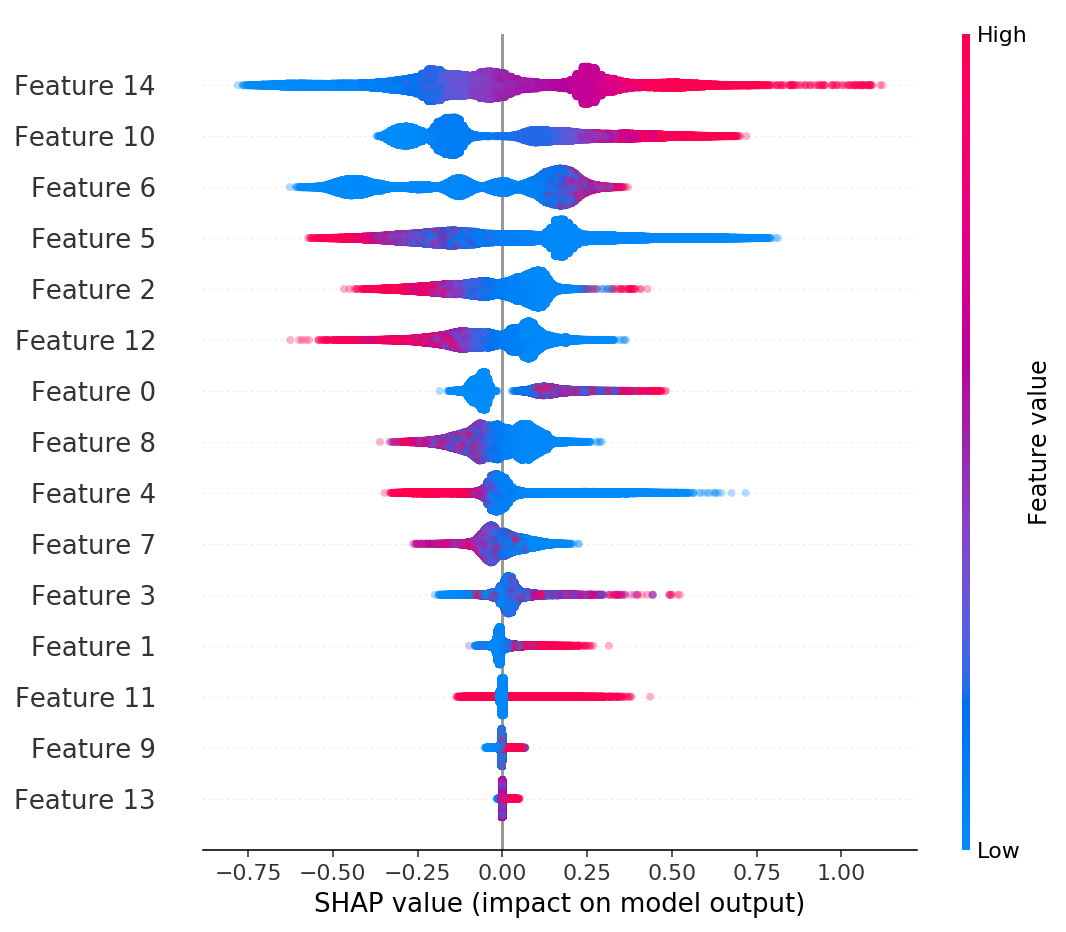

In [48]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [49]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [50]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

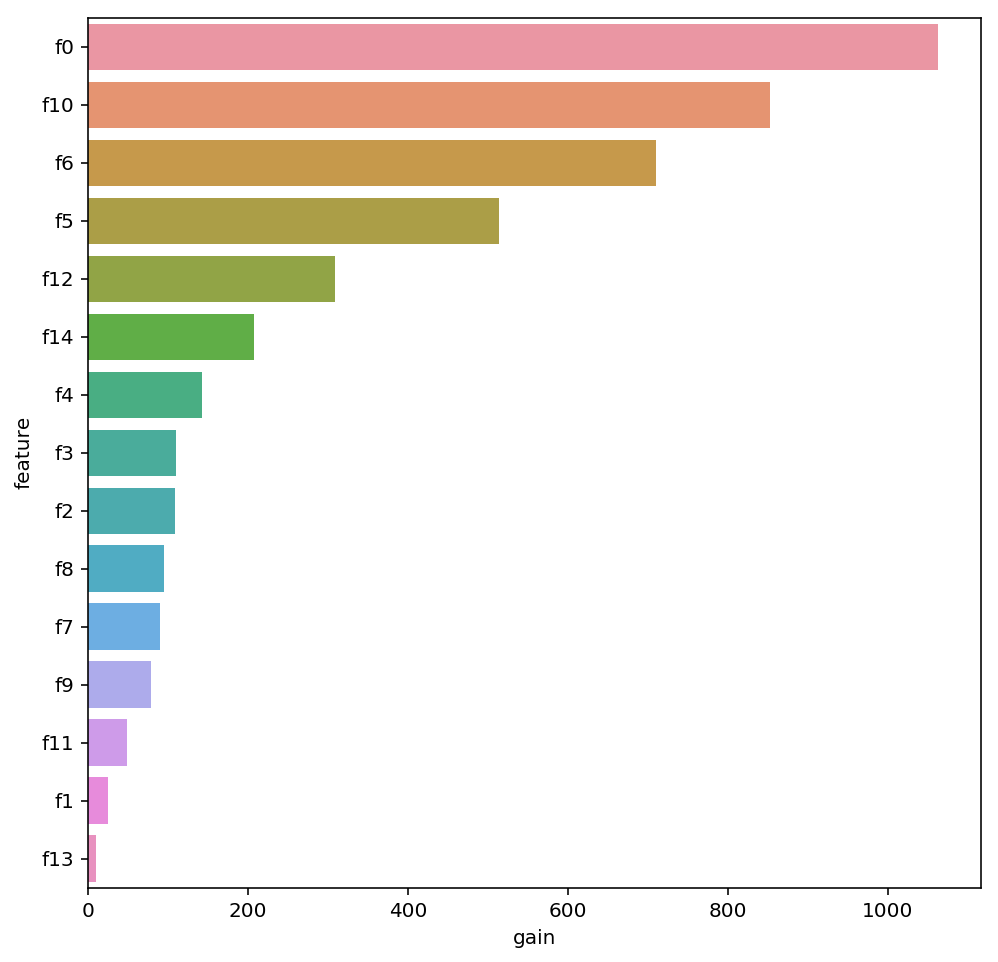

In [51]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [143]:
import xgboost as xgb

from pyspark.sql import Window
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import monotonically_increasing_id

In [127]:
def concat_dfs(df1, df2):
    window = Window.orderBy(F.lit('A'))
    df1 = df1.withColumn('_id', F.row_number().over(window))
    df2 = df2.withColumn('_id', F.row_number().over(window))
    df = df1.join(df2, on='_id').drop('_id')
    return df

In [161]:
class XgbLogRegModel(pyspark.ml.Model):
    def __init__(self, 
                 dim, 
                 xgb_checkpoint,
                 pipe_checkpoint,
                 lr_checkpoint):
        super(XgbLogRegModel, self).__init__()
        self.dim = dim
        
        # Checkpoints
        self.xgb_checkpoint = xgb_checkpoint
        self.pipe_checkpoint = pipe_checkpoint
        self.lr_checkpoint = lr_checkpoint
    
    def _get_booster(self):
        bst = xgb.Booster()
        bst.load_model(self.xgb_checkpoint)
        return bst
    
    def _get_pipe(self):
        return PipelineModel.load(self.pipe_checkpoint)
        
    def _get_lr_model(self):
        return LogisticRegressionModel.load(self.lr_checkpoint)
    
    def transform(self, df):
        bst = self._get_booster()
        
        dtest = xgb.DMatrix(df_to_csr(df, dim))
        leafs = bst.predict(dtest, pred_leaf=True)
        
        # Build new features
        num_samples, num_trees = leafs.shape
        leafs = leafs.tolist()
        columns = ['tree_' + str(i) for i in range(num_trees)]
        dataset = [leafs[it] for it in range(num_samples)]
        new_df = sqlContext.createDataFrame(dataset, columns)
        
        pipe = self._get_pipe()
        new_df = pipe.transform(new_df).select('tree_features')
        
        df = concat_dfs(df, new_df)
        
        lr_model = self._get_lr_model()
        result = lr_model.transform(df)
        result = result.drop('tree_features')
        
        return result

In [162]:
class XgbLogRegEstimator(pyspark.ml.Estimator):
    def __init__(self, 
                 featuresCol, 
                 labelCol,
                 predictionCol,
                 xgb_checkpoint='xgb_checkpoint',
                 pipe_checkpoint='pipe_checkpoint',
                 lr_checkpoint='lr_checkpoint'):
        super(XgbLogRegEstimator, self).__init__()
        
        # Column names
        self.featuresCol = featuresCol
        self.labelCol = labelCol
        self.predictionCol = predictionCol
        
        # Checkpoints
        self.xgb_checkpoint = xgb_checkpoint
        self.pipe_checkpoint = pipe_checkpoint
        self.lr_checkpoint = lr_checkpoint
    
    def _get_booster(self, train_df):
        estimator = XGBoostEstimator(
            featuresCol=self.featuresCol,
            labelCol=self.labelCol,
            predictionCol=self.predictionCol,
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        
        model = estimator.fit(train_df)
        model._call_java('booster').saveModel(self.xgb_checkpoint)
        
        bst = xgb.Booster()
        bst.load_model(self.xgb_checkpoint)
        
        return bst
    
    def _get_lr_model(self, train_df):
        lr = LogisticRegression(
            featuresCol='tree_features', 
            labelCol=self.labelCol,
            predictionCol=self.predictionCol, 
            maxIter=10,
            regParam=0.0, 
            elasticNetParam=0.0
        )

        lr_model = lr.fit(train_df)
        lr_model.write().overwrite().save(self.lr_checkpoint)
        
        return lr_model
    
    def _get_pipe(self, train_df, columns):
        columns_vec = [it + '_vec' for it in columns]
        onehot_encoder = OneHotEncoderEstimator(inputCols=columns, outputCols=columns_vec)
        assembler = VectorAssembler(inputCols=columns_vec, outputCol='tree_features')
        pipeline = Pipeline(stages=[onehot_encoder, assembler])
        pipe = pipeline.fit(train_df)
        pipe.write().overwrite().save(self.pipe_checkpoint)
        return pipe
        
    def fit(self, train_df, dim):
        bst = self._get_booster(train_df)

        dtrain = xgb.DMatrix(df_to_csr(train_df, dim))
        leafs = bst.predict(dtrain, pred_leaf=True)
        
        # Build new features
        num_samples, num_trees = leafs.shape
        leafs = leafs.tolist()
        labels = train_df.select(self.labelCol).collect()
        columns = ['tree_' + str(i) for i in range(num_trees)]
        dataset = [[labels[it][0]] + leafs[it] for it in range(num_samples)]
        train_df = sqlContext.createDataFrame(dataset, [self.labelCol] + columns)

        pipe = self._get_pipe(train_df, columns)    
        train_df = pipe.transform(train_df).select(self.labelCol, 'tree_features')
        
        lr_model = self._get_lr_model(train_df)
        
        return XgbLogRegModel(dim, self.xgb_checkpoint, self.pipe_checkpoint, self.lr_checkpoint)

## Train

In [163]:
xgb_log_reg_est = XgbLogRegEstimator(
    featuresCol='features', 
    labelCol='label', 
    predictionCol='prediction'
)

In [164]:
xgb_log_reg_model = xgb_log_reg_est.fit(train_df, dim=15)

[21:54:52] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [169]:
xgb_log_reg_metrics = {}
xgb_log_reg_metrics['ROC AUC'] = rocauc(xgb_log_reg_model, test_df, probabilities_col='probability')
xgb_log_reg_metrics['ROC AUC']

[22:11:37] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


0.7356230564057837

In [170]:
all_metrics['xgb_log_reg'] = xgb_log_reg_metrics

## Evaluation

In [ ]:
def calibration(model, df):
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [171]:
get_ate(all_metrics, 'logreg')

,xgb_mean_target,xgb_log_reg,logreg,xgb_baseline
ROC AUC,4.791543,4.768556,0.0,3.802283


### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [38]:
test_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_PATH)

In [39]:
test_df = test_df.fillna(0, subset=num_columns)
test_df = pipeline_model.transform(test_df)
test_df = test_df.select('id', 'features')

In [43]:
pred = model.transform(test_df).select('id', 'probabilities')
pred = pred.toPandas()
pred['proba'] = pred['probabilities'].map(lambda p: p[1] if not pd.isna(p[1]) else 0.)

In [45]:
pred.head()

,id,probabilities,proba
0,592705839438,"[0.6791693568229675, 0.32083064317703247]",0.320831
1,670015250683,"[0.7080352902412415, 0.29196470975875854]",0.291965
2,704375045413,"[0.8002722859382629, 0.19972769916057587]",0.199728
3,566936227781,"[0.8302028179168701, 0.16979719698429108]",0.169797
4,618475712763,"[0.6592246294021606, 0.34077540040016174]",0.340775


In [46]:
TEST_PREDICTON_PATH = 'test_pred.csv'

In [47]:
pred[['id', 'proba']].to_csv(TEST_PREDICTON_PATH, index=False)